In [377]:
# for data processing
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas() 
import itertools

# for plotting
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint

# for nlp
import gensim
from gensim.utils import simple_preprocess
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import tokenize
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.corpus import stopwords
import nltk
import gensim.corpora as corpora

# download required sources
nltk.download('vader_lexicon')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('tagsets')
nltk.download('stopwords')
nltk.download('words')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\lukas\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\lukas\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\lukas\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package tagsets to
[nltk_data]     C:\Users\lukas\AppData\Roaming\nltk_data...
[nltk_data]   Package tagsets is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lukas\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\lukas\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\words.zip.


True

Only take restaurants into account. We want to find out, what it is what makes restaurants go up or down in rating significantly.

In [2]:
size = 100000
business_chunks = pd.read_json('../data/yelp_academic_dataset_business.json', lines=True,
                    dtype={
                        "business_id": str,
                        "name": str,
                        "address": str,
                        "city": str,
                        "state": str,
                        "postal code": str,
                        "latitude": float,
                        "longitude": float,
                        "stars": float,
                        "review_count": int,
                        "is_open": int
                    }, chunksize=size)

chunk_list = []
for chunk in business_chunks:
    chunk = chunk[chunk['categories'].notnull()]
    
    # only keep restaurants
    chunk = chunk.loc[[('Restaurant' in x) for x in chunk['categories']]]
    
    # only in Vancouver
    chunk = chunk.loc[chunk['city'] == 'Vancouver']
    
    
    # only certain columns
    # chunk = chunk[['business_id', 'name','stars', 'is_open','review_count']]
    
    chunk_list.append(chunk)

restaurants = pd.concat(chunk_list, ignore_index=True, join='outer', axis=0)


# EDA on restaurants in Vancouver
A bit of explorative data analysis, to get used to the data and see if our business case is actually valid.

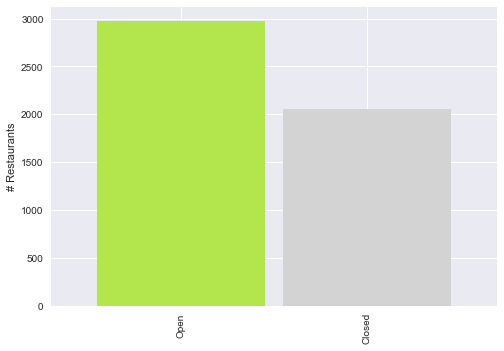

In [212]:
plt.style.use('seaborn')

restaurants['is_open_cat'] = restaurants.is_open.apply(lambda x : 'Open' if x == 1 else 'Closed')

ax = plt.subplot()
restaurants.is_open_cat.value_counts().plot(ax=ax, kind='bar', width=0.9, color=[(0.7,0.9,0.3), 'lightgrey'])
ax.set_ylabel('# Restaurants')
plt.show()

There are a lot of closed restaurants. Let's compare the average star rating.

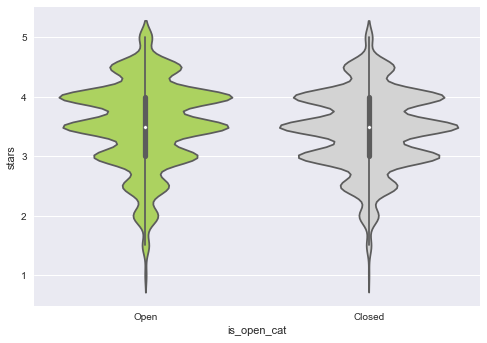

In [64]:
ax = plt.subplot()

my_palette = {"Open": (0.7,0.9,0.3), "Closed": "lightgrey"}

sns.violinplot(x='is_open_cat',y='stars', data=restaurants, ax = ax, palette = my_palette)
plt.show()

The differences between closed and open restaurants is only marginal. I still do expect some differences in the text ratings, though. 

Most users vote around 4 stars. 1 star is extremely seldom (the Canadians are truely polite people 😊). 

Let's now take a look at the restaurants in general. Plot the top 10most occurring categories.

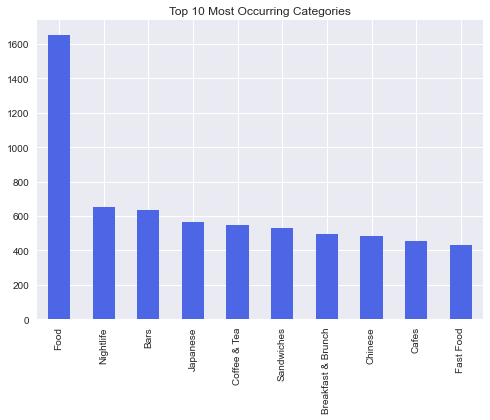

In [114]:
ax = plt.subplot()
categories = restaurants.categories.str.split(', ', expand=True)
categories['business_id'] = restaurants['business_id']
categories.melt('business_id', value_name='category').dropna().sort_values('business_id').query('category != "Restaurants"').category.value_counts()[:10].plot(kind='bar', ax=ax, color=(0.3,0.4,0.9))
ax.set_title('Top 10 Most Occurring Categories')
plt.show()

## Read the reviews
Now read the reviews, to see if they vary over time.

In [88]:
size = 1000000
review_chunks = pd.read_json('../data/yelp_academic_dataset_review.json', lines=True,
                    dtype={
                    "review_id": str,
                    "user_id": str,
                    "business_id": str,
                    "stars": int,
                    "date": str,
                    "text": str,
                    "useful": int,
                    "funny": int,
                    "cool": int,
                }, chunksize=size)

chunk_list = []
for chunk in review_chunks:
    # only keep tips of current or former elite users.
    chunk = chunk[chunk.business_id.isin(restaurants.business_id.unique())]
    chunk_list.append(chunk)

reviews = pd.concat(chunk_list, ignore_index=True, join='outer', axis=0)

reviews['yearmon'] = reviews['date'].str[0:7]
reviews['year'] = reviews['date'].str[0:4]
reviews['quarter'] = pd.to_datetime(reviews['date'], format='%Y-%m-%d').dt.quarter

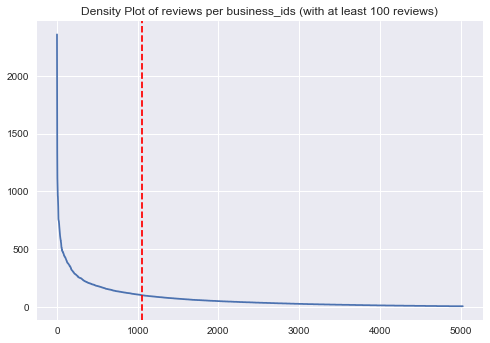

In [155]:
ax = plt.subplot()
line_at = 100

ax.set_title(f'Density Plot of reviews per business_ids (with at least {line_at} reviews)')
business_ids_with_sufficient_reviews = reviews.business_id.value_counts()[reviews.business_id.value_counts() > line_at].index.values
reviews.business_id.value_counts().reset_index()['business_id'].plot(ax=ax)
number_of_businesses_with_sufficient_reviews = sum(reviews.business_id.value_counts() > line_at)
ax.axvline(number_of_businesses_with_sufficient_reviews, linestyle='--', color = 'red')
plt.show()

We have roughly 1000 companies, that have more than 100 reviews. For these, we should be able to get a nice development of star ratings.

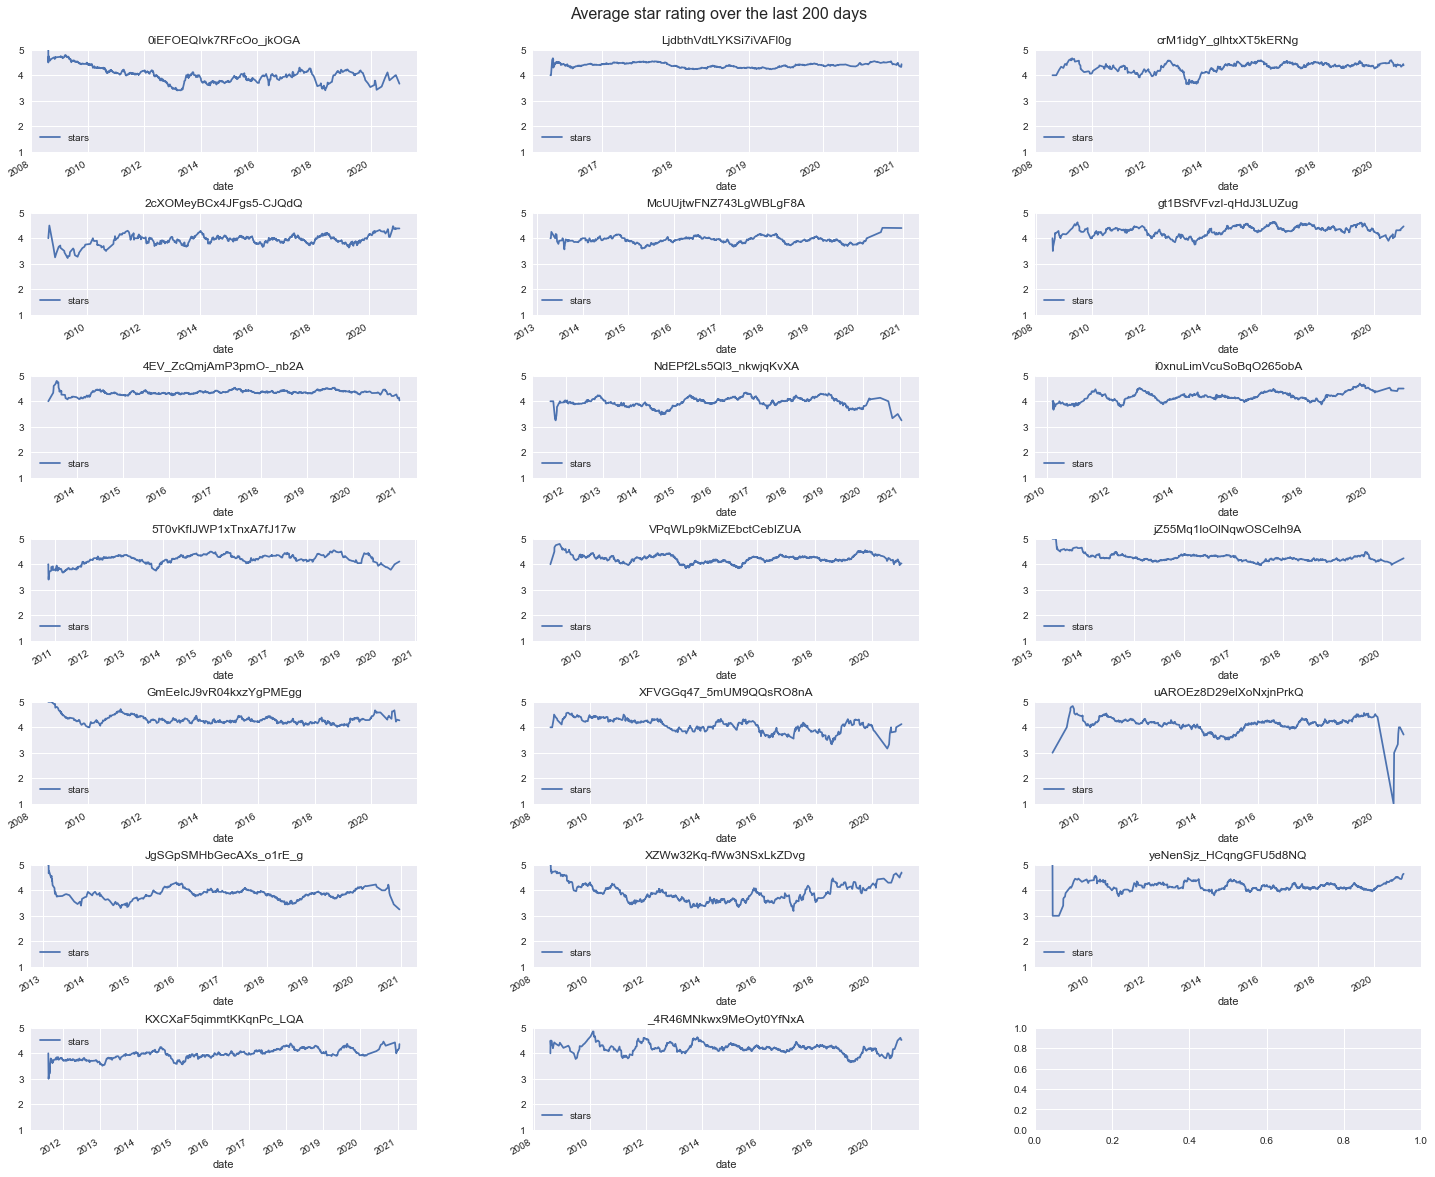

In [214]:
reviews['date'] = pd.to_datetime(reviews['date'], format='%Y-%m-%d')

mean_ratings_top_20 = reviews.loc[reviews.business_id.isin(business_ids_with_sufficient_reviews[:20]), ['business_id', 'stars', 'date']].set_index('date', inplace=False).sort_index().groupby('business_id').rolling(window='200D').agg({'stars': 'mean'})

fig, ax = plt.subplots(7,3, figsize=(20,20))
fig.tight_layout()
fig.subplots_adjust(hspace=0.6, wspace=0.3, top=0.95)
fig.suptitle('Average star rating over the last 200 days', fontsize=16)
y = 0
for i, (name, group) in enumerate(mean_ratings_top_20.groupby('business_id')):
    # calc index
    x = i % 7
    if i != 0 and x == 0:
        y += 1
    
    ax[x,y].set_ylim(1,5)
    group.reset_index().plot(x='date', y='stars', ax=ax[x,y], title=name)
    
    if i ==20:
        break

Some restaurants in this sample vary a bit, but overall they are all pretty much constantly around 4. This might be due to a bias in the users ratings. For example, if a restaurant is well known and has a very good rating, but customers are extremely unhappy, they might resort to rating it 3 stars, whilst at other places they would have rated it 1 star. The _anchor effect_ could be a potential explanation for this behavior.

Additionally, most of the times, users place reviews when they have extreme feelings about the restaurants and will vote accordingly (1 for extremely upset and 5 for extremely happy. Thus, it is unrealistic for businesses to receive constantly ratings close to 5.

However, if we are able to analyze the true sentiment of the users in their textual review, we might be able to ignore the star rating and add a secondary "__sentiment score__". In combination with topic modeling, we could potentially extract topics and assign the sentiment score to the topics. Thus, we would end up with a more granular scoring for e.g. food, service, atmosphere, etc.

With that score, we might be able to give a more realistic view onto things for the businesses, to try and find out what causes a drop in ratings and what they should be working on. We will deliver this as shown above on a rolling window of the last X days. That way, business owners are able to react more quickly to recent changes in their ratings and find out what they need to be working on.

For users, we might be able to add this as additional filters to the search for restaurants. That way users are able to filter the search results with a more realistic search.

# Implementation Plan
<img src='../resources/implementation_plan.jpg' />

1. Sentiment analysis with VADER. VADER was developed to perform well with texts based on social media and therefore is a great choice for the yelp dataset.
2. Topic extraction with LDA. This requires a bit of preprocessing and finetuning. We expect to end up with topics that are relevant to the restaurant business, e.g. food, service, and atmosphere
3. Topic naming with word embeddings. Usually humans have to name the topics found by LDA. However, we want to be totally crazy and use the transitive features of word embeddings and find topic names based on the top X words per topic.
4. Combining the sentiment with the topics to end up with a list of sentiments per topic.

# Sentiment analysis with VADER

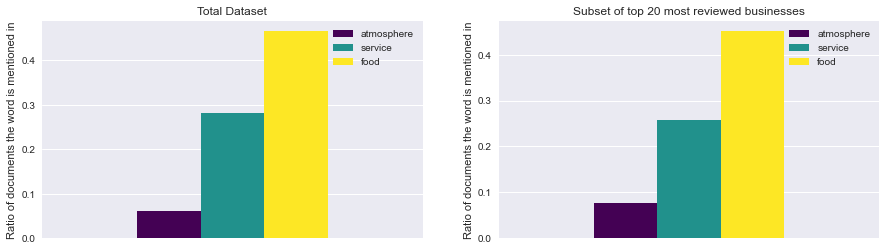

In [263]:
exemplary_occurrences = pd.DataFrame({
    'atmosphere': reviews.text.str.contains('atmosphere').mean(),
    'service': reviews.text.str.contains('service').mean(),
    'food': reviews.text.str.contains('food').mean()
}, index=['Occurences of words'])

exemplary_occurrences_subset = pd.DataFrame({
    'atmosphere': reviews.loc[reviews.business_id.isin(business_ids_with_sufficient_reviews[:20])].text.str.contains('atmosphere').mean(),
    'service': reviews.loc[reviews.business_id.isin(business_ids_with_sufficient_reviews[:20])].text.str.contains('service').mean(),
    'food': reviews.loc[reviews.business_id.isin(business_ids_with_sufficient_reviews[:20])].text.str.contains('food').mean()
}, index=['Occurences of words'])

fig, ax = plt.subplots(1,2, figsize=(15,4))
ax[0].axes.get_xaxis().set_visible(False)
ax[0].set_ylabel('Ratio of documents the word is mentioned in')
ax[0].set_title('Total Dataset')
exemplary_occurrences.plot(kind='bar', ax=ax[0], colormap='viridis')

ax[1].axes.get_xaxis().set_visible(False)
ax[1].set_ylabel('Ratio of documents the word is mentioned in')
ax[1].set_title('Subset of top 20 most reviewed businesses')
exemplary_occurrences_subset.plot(kind='bar', ax=ax[1], colormap='viridis')

plt.show()

The words ratio is about the same for our subset, so let's use the subset for now to get quicker results

In [347]:
top20_reviews = reviews.loc[reviews.business_id.isin(business_ids_with_sufficient_reviews[:20])]

words = set(nltk.corpus.words.words())
def remove_non_english(text):
    return " ".join(w for w in nltk.wordpunct_tokenize(text) if w.lower() in words or w.isdigit())

print(top20_reviews.shape)
top20_reviews = top20_reviews.assign(english=top20_reviews.text.map(remove_non_english))
top20_reviews = top20_reviews[top20_reviews.english != '']
print(top20_reviews.shape)

def tokenize_and_score(row):
    tokenized_sentences = tokenize.sent_tokenize(row)
    
    scores = list(map(lambda x : sid.polarity_scores(x)['compound'], tokenized_sentences))
    
    return tokenized_sentences, scores

top20_reviews['tokenized'], top20_reviews['scores'] = zip(*(top20_reviews.text.progress_map(tokenize_and_score)))

# # TODO: should be done in one map with the scoring.
# top20_reviews = top20_reviews.assign(tokenized=top20_reviews.text.map(lambda x: tokenize.sent_tokenize(x)))

# # vader score
# top20_reviews = top20_reviews.assign(score=top20_reviews.text.map(lambda x : sid.polarity_scores(x)['compound']))

top20_reviews[['text', 'tokenized', 'scores']].head(10)

__Caveat:__ We should probably do it per sentence, as some sentences have separat topics. E.g. "Baristas are great. All other staff is soooo lost and vacant."

Solved

# LDA Topic Modelling
Game Plan for this step:
1. Basic preprocessing (lower case)
2. POS Tagging and filter to only nouns (relevant to topics)
3. Removal of stop words // there should not be any at this point anymore, but just to make sure
4. Stem words
5. Run LDA on the preprocessed text as a whole document.

__Caveat:__ We should do this per sentence to get a more fine-grain result. For now, we will stick with this solution, however.

Solved

For reference of the available POS tags in nltk refer to `nltk.help.upenn_tagset()`

In [349]:
#POS tagging first to utilize sentences
stemmer = SnowballStemmer('english')

def pos_tagging(row):
    return list(filter(lambda x: x != [], [keep_nouns(sentence) for sentence in row]))

def preprocess(sentence):
    '''
    0. Convert to lower case
    1. Only allow nouns. 
    2. Remove stopwords
    3. Stem words
    '''
    pos_tag_tuples = nltk.pos_tag(nltk.word_tokenize(sentence.lower())) # lower case to avoid weird nouns
    
    nouns = []
    for pos_tag_tuple in pos_tag_tuples:
        if pos_tag_tuple[1] in ['NN', 'NNS', 'NNP', 'NNPS']:
            # keep the word
            # but only if it is not a stop word
            if pos_tag_tuple[0] not in stopwords.words('english'):
                nouns.append(stemmer.stem(pos_tag_tuple[0]))
    
    return nouns


top20_reviews = top20_reviews.assign(noun_sentences = top20_reviews.tokenized.progress_map(pos_tagging))
# tmp = top20_reviews.head(10).tokenized.progress_map(pos_tagging)

100%|████████████████████████████████████████████████████████████████████████████| 21918/21918 [18:16<00:00, 19.98it/s]


In [350]:
list_of_sentences = list(itertools.chain.from_iterable(top20_reviews['noun_sentences'].values))

In [326]:
# Create Dictionary
id2word = corpora.Dictionary(list_of_sentences)

# Create Corpus
texts = list_of_sentences

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [327]:
# number of topics
num_topics = 12

# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)

# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.198*"place" + 0.185*"food" + 0.051*"vancouv" + 0.026*"time" + '
  '0.024*"fish" + 0.024*"friend" + 0.019*"waiter" + 0.017*"qualiti" + '
  '0.014*"miso" + 0.013*"waitress"'),
 (1,
  '0.067*"price" + 0.059*"peopl" + 0.042*"broth" + 0.038*"wine" + '
  '0.032*"bread" + 0.030*"select" + 0.029*"piec" + 0.027*"atmospher" + '
  '0.026*"bit" + 0.023*"cours"'),
 (2,
  '0.047*"ramen" + 0.038*"flavor" + 0.032*"mussel" + 0.028*"pork" + '
  '0.025*"egg" + 0.023*"fri" + 0.022*"side" + 0.020*"chees" + 0.019*"sauc" + '
  '0.019*"seafood"'),
 (3,
  '0.077*"menu" + 0.064*"tabl" + 0.053*"staff" + 0.041*"thing" + 0.032*"item" '
  '+ 0.029*"beer" + 0.024*"bowl" + 0.021*"seat" + 0.020*"chef" + 0.019*"bar"'),
 (4,
  '0.102*"restaur" + 0.054*"dinner" + 0.042*"brunch" + 0.041*"everyth" + '
  '0.032*"lunch" + 0.027*"review" + 0.027*"vancouv" + 0.027*"server" + '
  '0.019*"cocktail" + 0.017*"plate"'),
 (5,
  '0.206*"servic" + 0.085*"food" + 0.070*"meal" + 0.030*"line" + 0.026*"lot" + '
  '0.026*"noth" +

In [330]:
import pyLDAvis.gensim_models
import pickle 
import os
import pyLDAvis

# Visualize the topics
pyLDAvis.enable_notebook()

LDAvis_data_filepath = os.path.join('../results/ldavis_prepared_'+str(num_topics))

# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
        
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
    
pyLDAvis.save_html(LDAvis_prepared, '../results/ldavis_prepared_'+ str(num_topics) +'.html')

LDAvis_prepared

C:\ProgramData\Anaconda3\envs\yelp\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.271274 -0.071674       1        1  12.240342
4     -0.186714 -0.018350       2        1   9.820995
0     -0.210974 -0.126029       3        1   9.423357
10     0.204474 -0.127822       4        1   9.116036
3     -0.108530  0.218681       5        1   8.916990
7      0.138999  0.203420       6        1   8.080604
11     0.001082 -0.161764       7        1   7.972815
5     -0.213012 -0.067581       8        1   7.468429
6     -0.036366  0.140926       9        1   7.015124
1     -0.008839 -0.029901      10        1   6.771719
8      0.146983  0.010992      11        1   6.658175
9      0.001622  0.029101      12        1   6.515415, topic_info=        Term          Freq         Total Category  logprob  loglift
9     servic   8898.000000   8898.000000  Default  30.0000  30.0000
54     place  12571.000000  12571.000000  Default  29.0000  29.0000
7       food  15176.000000  15176.000000  Default  28.0000  28.0000
97      dish   6743.000000   6743.000000  Default  27.0000  27.0000
27      time   8378.000000   8378.000000  Default  26.0000  26.0000
...      ...           ...           ...      ...      ...      ...
423   amount    272.697513    731.523865  Topic12  -4.9157   1.7442
1334    even    223.656123    636.392281  Topic12  -5.1140   1.6853
244      fan    230.683586    937.680291  Topic12  -5.0831   1.3286
7       food    341.979575  15176.870186  Topic12  -4.6893  -1.0618
10       bar    225.298465   2499.366977  Topic12  -5.1067   0.3246

[822 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
41        1  0.005221      %
41        3  0.002610      %
41        4  0.837943      %
41        5  0.049598      %
41        6  0.046987      %
...     ...       ...    ...
453       8  0.002969  yummi
453      10  0.002969  yummi
453      11  0.938145  yummi
1619      9  0.983619      ~
2297      5  0.980613      à

[3267 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 5, 1, 11, 4, 8, 12, 6, 7, 2, 9, 10])

Possibly replace LDA with https://github.com/adjidieng/ETM in the future. Seems promising

In [365]:
# human assigns titles to topics
food = [1, 4, 6, 11, 12]
service = [5, 7, 8, 9] # 9 could be separated as time
atmosphere = [2,3]
price = [10]

use categories to assign sentiment of vader to text

In [375]:
top20_reviews[7898:7900]

,review_id,user_id,business_id,stars,useful,funny,cool,text,date,yearmon,year,quarter,tokenized,scores,noun_sentences
126023,OGXlTh3WOl17Zee4KmJZWA,SSECutZitKtpH-0b3SXpCw,LjdbthVdtLYKSi7iVAFl0g,3,0,0,0,1時間程並んで入店。トリプルスタックパンケーキとザ・チャーリーボウルを注文。パンケーキは甘す...,2018-06-24 22:44:38,2018-06,2018,2,[1時間程並んで入店。トリプルスタックパンケーキとザ・チャーリーボウルを注文。パンケーキは甘...,[0.0],[]
126026,Xt3YHucYmI1Qre6w96kCxA,ZYoexLzRb4Rs2ZuJv4kMAA,LjdbthVdtLYKSi7iVAFl0g,5,0,0,1,Finally decided to see what the constant lines...,2018-01-28 03:24:46,2018-01,2018,1,[Finally decided to see what the constant line...,"[0.4303, 0.0, 0.4215, 0.6249, 0.6249, 0.8887, ...","[[line], [line, weekday, case], [line, group, ..."


In [351]:
top20_reviews.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date,yearmon,year,quarter,tokenized,scores,noun_sentences
1,ucFOnqgaV40oQ2YNyz5ddQ,JHXQEayrDHOWGexs0dCviA,KXCXaF5qimmtKKqnPc_LQA,1,0,0,0,Great coffee and pastries. Baristas are excell...,2018-03-03 23:45:25,2018-03,2018,1,"[Great coffee and pastries., Baristas are exce...","[0.6249, 0.5719, -0.3182]","[[coffe, pastri], [barista], [staff]]"
4,P320Yt8vFD3yjI34hq-umg,IMfkbLVt_GJfD7zJ9T4fcw,VPqWLp9kMiZEbctCebIZUA,3,0,0,0,"Overall is good, is worth the line up I don't ...",2018-09-25 03:22:50,2018-09,2018,3,"[Overall is good, is worth the line up I don't...","[0.5859, 0.743]","[[line, addict, go], [food, servic, hype]]"
5,dVNBiJgZvZpXkUNaWL9Ljw,EuuWkZ_EA2IjsJCPOCt9UA,VPqWLp9kMiZEbctCebIZUA,2,1,1,0,So we sat at the bar after a 45 minute wait. E...,2015-09-23 23:35:46,2015-09,2015,3,"[So we sat at the bar after a 45 minute wait.,...","[0.0, 0.7579, 0.2263, 0.0, 0.0, -0.4019, 0.0, ...","[[bar, minut, wait], [coffe, food, lavend, moc..."
9,VIBVm2mi4ydOaHbah68bzA,vLOApYl6w7K455f_Rfprvw,VPqWLp9kMiZEbctCebIZUA,2,1,0,0,I was trying to decide if I should give two or...,2013-06-24 08:21:19,2013-06,2013,2,[I was trying to decide if I should give two o...,"[0.0, 0.0, 0.0, 0.0, -0.1513, 0.4019, 0.0, 0.4...","[[star], [star], [brief], [food, drink, meh], ..."
21,BU_D1TAU1J3c8SMyDLdNCg,vAfLRIe_AqCw6AAJCWFuGw,VPqWLp9kMiZEbctCebIZUA,4,0,0,0,"Finally, made it out to Cafe Medina and will b...",2010-01-08 01:05:05,2010-01,2010,1,"[Finally, made it out to Cafe Medina and will ...","[0.3182, 0.5859, 0.0, 0.6114, 0.0, 0.2609, 0.7...","[[medina], [lavend, latt], [waffl, chocol, pis..."


In [372]:
def get_topic_scores(row):
    sentences_bow = [id2word.doc2bow(text) for text in row.noun_sentences]
    sentence_scores = list(lda_model.get_document_topics(sentences_bow))
    score_food = 0
    score_service = 0
    score_price = 0
    score_atmosphere = 0
    print(sentence
    for topic_scores, vader_score in zip(sentence_scores, row.scores):
        if type(topic_scores) == int:
            print(row)
        topics, scores = zip(*topic_scores)
        topic = topics[np.argmax(scores)]
        if topic in food:
            score_food += vader_score
        if topic in atmosphere:
            score_atmosphere += vader_score
        if topic in service:
            score_service += vader_score
        if topic in price:
            score_price += vader_score
    return score_food, score_service, score_price, score_atmosphere
    

top20_reviews['score_food'], top20_reviews['score_service'], top20_reviews['score_price'], top20_reviews['score_atmosphere'] = \
    zip(*top20_reviews.progress_apply(get_topic_scores, axis=1))

 36%|███████████████████████████▍                                                | 7899/21918 [00:38<01:07, 206.48it/s]


TypeError: 'int' object is not iterable

In [371]:
# add scores together and scale from 1 - 5 for each restaurant

Two things I realize.

1. My dataset is too biased on restaurants with good ratings (we have only the top restaurants, and they usually have high ratings, if they have so many, it means many ppl go there and therefore it must not be shabby)
2. LDA could possibly perform better, if I only train it on nouns and use VADER for sentiment regarding those nouns. Maybe then I am able to split 

In [222]:
#importing wordtovec embeddings 
from gensim.models import KeyedVectors
pretrained_embeddings_path = "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"
word2vec = KeyedVectors.load_word2vec_format(pretrained_embeddings_path, binary=True)

KeyboardInterrupt: 